In [22]:
%load_ext autoreload
%autoreload 2


from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

from spektral.datasets import delaunay
from spektral.layers import GraphAttention, GlobalAttentionPool
from spektral.utils import localpooling_filter

from sklearn.decomposition import TruncatedSVD

import numpy as np
from eden import graph
import networkx as nx

import load_data as ld
import utilities
from evaluator import Evaluator
from embedder import Embedder
from embedder import Transformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import load_data as ld
graphs, labels = ld.load_data("MUTAG")

functions = [utilities.degree,utilities.clust_coefficient,utilities.max_degree_neighbors]
graphs = utilities.add_info_to_nodes(graphs,functions)

In [24]:
# n_classes = len(np.unique(labels))

dim=[2,4]
times= 1
vetcoriz = graph.Vectorizer(complexity = 1)
m_8 = Transformer(vetcoriz, has_fit = False)
pca_2 = TruncatedSVD()
m_9 = Transformer(pca_2)

emb_1 = Embedder([m_8,m_9], name="Vectorize-1, PCA")

vetcoriz = graph.Vectorizer(complexity = 5)
m_8 = Transformer(vetcoriz, has_fit = False)
pca_2 = TruncatedSVD()
m_9 = Transformer(pca_2)

emb_4 = Embedder([m_8,m_9], name="Vectorize-5, PCA")

emb = [emb_1,emb_4]


vis = utilities.repeat_n_times(graphs,labels,emb,dim,times,test_size=0.3)


	 iteration n: 1
	 	 dim:  2
	 	 	  Vectorize-1, PCA


/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted

	 	 	  Vectorize-5, PCA
	 	 dim:  4
	 	 	  Vectorize-1, PCA


/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted

	 	 	  Vectorize-5, PCA


/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/antonio/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
%load_ext autoreload
%autoreload 2

from visualizator import Visualizator

vis.summary(std=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
*****************************
METRIC: accuracy
                     2      4    mean
----------------  ----  -----  ------
Vectorize-1, PCA  0.72  0.748   0.734
Vectorize-5, PCA  0.66  0.601   0.631


In [2]:

def repeat_n_times(adj,x,labels,dim,times,emb, test_size=0.3):

    n_classifiers = len(emb)
    names = []
    for i in emb:
        names.append(i.name)
        
    vis = Visualizator(dim, n_classifiers = n_classifiers,models_names=names)
    # Preprocessing
    fltr = localpooling_filter(adj.copy())


    for t in range(0,times):
           # Train/test split
        fltr_train, fltr_test, x_train, x_test, y_train, y_test = train_test_split(fltr, x, labels, test_size=0.3)
        print("\t iteration n:",t+1)
        for d in range(0,len(dim)):
            print("\t \t dim: ",int(dim[d]))
            dimension_embedding = int(dim[d])


            for j in range(0,len(emb)):
                #change dimenction of the last embedder in estimators
                emb[j].estimators[-1].estimator.n_components=dimension_embedding
                X_train = [x_train, fltr_train]
                X_test = [x_test, fltr_test]
                X_small = emb[j].fit(X_train,y_train).transform(X_test)

                evaluator = Evaluator(KNeighborsClassifier(n_neighbors=1))
                # compute the metrics
                
                ################################## TMP
                tmp = []
                for i in y_test:
                    if(i[0] == 1):
                        tmp.append(0)
                    else:
                        tmp.append(1)
                acc, pre, rec, f = evaluator.performance_with_kfold(X_small,tmp)

                # add the computed performance in the visualizzator
                vis.add_metrics(acc,pre,rec,f,j,d)

    vis.y_test = y_test
    return(vis)


In [41]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from visualizator import Visualizator


learning_rate = 0.001



#adj, x_olg, y_old = delaunay.generate_data(return_type='numpy', classes=[0, 5], n_samples_in_class=1000)
adj, x, _ , y = ld.load_data("MUTAG",output_type="numpy",one_hot=True)



##### DEFINISCI MODELLO ORIGINALE
X_in = Input(shape=(28, 3))
filter_in = Input((28, 28))
gc1 = GraphAttention(32, activation='relu')([X_in, filter_in])
pool = GlobalAttentionPool(128)(gc1)
output = Dense(2, activation='softmax')(pool)
model = Model(inputs=[X_in, filter_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


##### CREA IL SECONDO MODELLO
X_in_1 = Input(shape=(28, 3))
filter_in_1 = Input((28, 28))
gc1_1 = GraphAttention(32, activation='relu')([X_in_1, filter_in_1])
pool_1 = GlobalAttentionPool(128)(gc1_1)
model_1 = Model(inputs=[X_in_1, filter_in_1], outputs=pool_1)
model_1.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc'])




my_GNN = Model_GNN(original_model = model,
                                  new_model = model_1,
                                  batch_size = 32,
                                  validation_split = 0.1,
                                  epochs = 3)


m_1 = Transformer(my_GNN)
pca = TruncatedSVD()
m_2 = Transformer(pca)
emb = Embedder([m_1,m_2])

dim = [2,10,100]




n_classifiers = 1
names = "test"
vis = Visualizator(dim, n_classifiers = n_classifiers,models_names=names)
# Preprocessing
fltr = localpooling_filter(adj.copy())


fltr_train, fltr_test, x_train, x_test, y_train, y_test = train_test_split(fltr, x, y, test_size=0.3)

for d in range(0,len(dim)):
    print("\t \t dim: ",int(dim[d]))
    dimension_embedding = int(dim[d])


    #change dimenction of the last embedder in estimators
    emb.estimators[-1].estimator.n_components=dimension_embedding
    ######## reset the states
    emb.estimators[0].estimator.reset_state()

    X_train = [x_train, fltr_train]
    X_test = [x_test, fltr_test]
    X_small = emb.fit(X_train,y_train).transform(X_test)

    evaluator = Evaluator(KNeighborsClassifier(n_neighbors=1))
    # compute the metrics

    ################################## TMP
    tmp = []
    for i in y_test:
        if(i[0] == 1):
            tmp.append(0)
        else:
            tmp.append(1)
    acc, pre, rec, f = evaluator.performance_with_kfold(X_small,tmp)
    vis.y_test = tmp

    # add the computed performance in the visualizzator
    vis.add_metrics(acc,pre,rec,f,0,d)




	 	 dim:  2
Train on 117 samples, validate on 14 samples
Epoch 1/100
117/117 [==============================] - 3s 27ms/step - loss: 0.7595 - acc: 0.4530 - val_loss: 0.4235 - val_acc: 0.8571
Epoch 2/100
117/117 [==============================] - 0s 1ms/step - loss: 0.6653 - acc: 0.6239 - val_loss: 0.4318 - val_acc: 0.8571
Epoch 3/100
117/117 [==============================] - 0s 1ms/step - loss: 0.5487 - acc: 0.6496 - val_loss: 0.6215 - val_acc: 0.6429
Epoch 4/100
117/117 [==============================] - 0s 1ms/step - loss: 0.5526 - acc: 0.8205 - val_loss: 0.5241 - val_acc: 0.7857
Epoch 5/100
117/117 [==============================] - 0s 1ms/step - loss: 0.4914 - acc: 0.6838 - val_loss: 0.4339 - val_acc: 0.9286
Epoch 6/100
117/117 [==============================] - 0s 1ms/step - loss: 0.4753 - acc: 0.6838 - val_loss: 0.5111 - val_acc: 0.7857
Epoch 7/100
117/117 [==============================] - 0s 1ms/step - loss: 0.4480 - acc: 0.7949 - val_loss: 0.5955 - val_acc: 0.6429
Epoch 8/100

Epoch 62/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3338 - acc: 0.8632 - val_loss: 0.8561 - val_acc: 0.7143
Epoch 63/100
117/117 [==============================] - 0s 909us/step - loss: 0.3239 - acc: 0.8803 - val_loss: 0.7504 - val_acc: 0.7143
Epoch 64/100
117/117 [==============================] - 0s 990us/step - loss: 0.3345 - acc: 0.8803 - val_loss: 0.7975 - val_acc: 0.7143
Epoch 65/100
117/117 [==============================] - 0s 803us/step - loss: 0.3277 - acc: 0.8718 - val_loss: 0.7933 - val_acc: 0.7143
Epoch 66/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3264 - acc: 0.8718 - val_loss: 0.8384 - val_acc: 0.7143
Epoch 67/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3268 - acc: 0.8718 - val_loss: 0.7853 - val_acc: 0.7143
Epoch 68/100
117/117 [==============================] - 0s 957us/step - loss: 0.3288 - acc: 0.8803 - val_loss: 0.7993 - val_acc: 0.7143
Epoch 69/100
117/117 [==============================] 

117/117 [==============================] - 0s 996us/step - loss: 0.3270 - acc: 0.8632 - val_loss: 0.7509 - val_acc: 0.7143
Epoch 23/100
117/117 [==============================] - 0s 961us/step - loss: 0.3597 - acc: 0.8718 - val_loss: 0.7077 - val_acc: 0.7143
Epoch 24/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3316 - acc: 0.8803 - val_loss: 0.9043 - val_acc: 0.6429
Epoch 25/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3386 - acc: 0.8803 - val_loss: 0.8013 - val_acc: 0.7143
Epoch 26/100
117/117 [==============================] - 0s 1ms/step - loss: 0.3249 - acc: 0.8718 - val_loss: 0.6981 - val_acc: 0.7143
Epoch 27/100
117/117 [==============================] - 0s 983us/step - loss: 0.3411 - acc: 0.8718 - val_loss: 0.8242 - val_acc: 0.7143
Epoch 28/100
117/117 [==============================] - 0s 936us/step - loss: 0.3430 - acc: 0.8547 - val_loss: 0.8470 - val_acc: 0.7143
Epoch 29/100
117/117 [==============================] - 0s 949us/st

117/117 [==============================] - 0s 1ms/step - loss: 0.3523 - acc: 0.8632 - val_loss: 0.8886 - val_acc: 0.6429
Epoch 43/100
117/117 [==============================] - 0s 963us/step - loss: 0.3228 - acc: 0.8632 - val_loss: 0.7227 - val_acc: 0.7143
Epoch 44/100
117/117 [==============================] - 0s 879us/step - loss: 0.3356 - acc: 0.8803 - val_loss: 0.7501 - val_acc: 0.7143
Epoch 45/100
117/117 [==============================] - 0s 963us/step - loss: 0.3249 - acc: 0.8803 - val_loss: 0.8074 - val_acc: 0.7143
Epoch 46/100
117/117 [==============================] - 0s 931us/step - loss: 0.3313 - acc: 0.8632 - val_loss: 0.8698 - val_acc: 0.7143
Epoch 47/100
117/117 [==============================] - 0s 895us/step - loss: 0.3284 - acc: 0.8632 - val_loss: 0.7778 - val_acc: 0.7143
Epoch 48/100
117/117 [==============================] - 0s 974us/step - loss: 0.3286 - acc: 0.8718 - val_loss: 0.7806 - val_acc: 0.7143
Epoch 49/100
117/117 [==============================] - 0s 956u

Dimensions:  [2, 10, 100]

*****************************
Method:  t
               2     10    100
---------  -----  -----  -----
Accuracy   0.86   0.897  0.877
Precision  0.892  0.942  0.91
Recall     0.925  0.925  0.925
F1         0.905  0.926  0.913

**********************************************************
Dims:  [2, 10, 100]
Model:  t



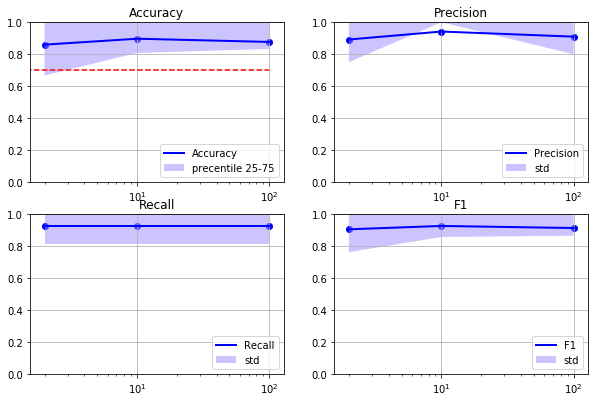

In [42]:
vis.summarize()
vis.plot(model=0)

Dimensions:  [2, 10, 100]

*****************************
Method:  t
               2     10    100
---------  -----  -----  -----
Accuracy   0.837  0.837  0.853
Precision  0.865  0.865  0.87
Recall     0.925  0.925  0.95
F1         0.892  0.892  0.906

**********************************************************
Dims:  [2, 10, 100]
Model:  t



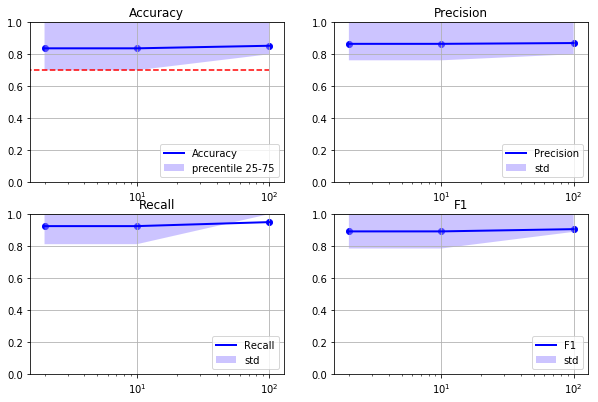

In [38]:
vis.summarize()
vis.plot(model=0)

Dimensions:  [2, 10, 100]

*****************************
Method:  t
               2     10    100
---------  -----  -----  -----
Accuracy   0.768  0.805  0.788
Precision  0.797  0.825  0.812
Recall     0.925  0.925  0.925
F1         0.846  0.865  0.857

**********************************************************
Dims:  [2, 10, 100]
Model:  t



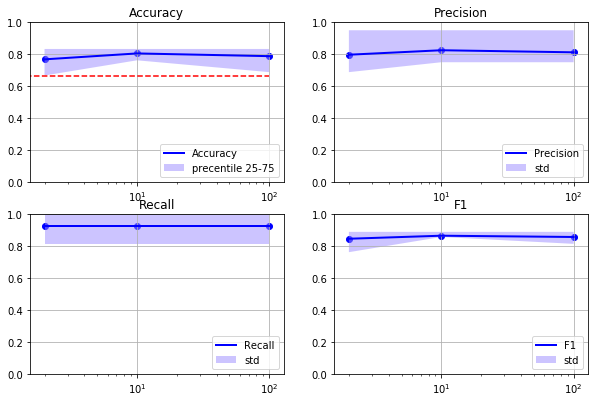

In [36]:
vis.summarize()
vis.plot(model=0)

In [25]:
from keras import layers
adj, x, _ , y = ld.load_data("MUTAG",output_type="numpy",one_hot=True)
# Preprocessing
fltr = localpooling_filter(adj.copy())

fltr_train, fltr_test, x_train, x_test, y_train, y_test = train_test_split(fltr, x, y, test_size=0.3)

##### DEFINISCI MODELLO ORIGINALE
X_in_2 = Input(shape=(28, 3))
filter_in_2 = Input((28, 28))
gc1_2 = GraphAttention(32, activation='relu')([X_in_2, filter_in_2])
pool_2 = GlobalAttentionPool(128)(gc1_2)
output_2 = Dense(2, activation='softmax')(pool_2)
model_2 = Model(inputs=[X_in_2, filter_in_2], outputs=output_2)
optimizer = Adam(lr=0.0001)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
w = model_2.get_weights()[0][0]
print(w)

model_2.fit([x_train, fltr_train],y_train,
               batch_size=32,
              validation_split=0.3,
              epochs=3)

w_dopo = model_2.get_weights()[0][0]
print(w)
print(w_dopo)

[ 0.35292056  0.32138368  0.14733836  0.15153697 -0.39088798  0.33246025
 -0.07860363 -0.11765525  0.3898653   0.3114544  -0.17784671 -0.37541032
  0.14516655 -0.24021336 -0.04750428 -0.0064806   0.06910995 -0.04751828
 -0.21911627 -0.00974432  0.28807232 -0.026703   -0.22671098 -0.36089206
 -0.10601017 -0.2676356   0.3694701   0.08122963  0.36552355  0.3973324
  0.07093805  0.40463284]
Train on 91 samples, validate on 40 samples
Epoch 1/3
91/91 [==============================] - 2s 25ms/step - loss: 3.1448 - acc: 0.3407 - val_loss: 3.3176 - val_acc: 0.2500
Epoch 2/3
91/91 [==============================] - 0s 1ms/step - loss: 2.6805 - acc: 0.3407 - val_loss: 2.8006 - val_acc: 0.2500
Epoch 3/3
91/91 [==============================] - 0s 1ms/step - loss: 2.2511 - acc: 0.3407 - val_loss: 2.2973 - val_acc: 0.2500
[ 0.35292056  0.32138368  0.14733836  0.15153697 -0.39088798  0.33246025
 -0.07860363 -0.11765525  0.3898653   0.3114544  -0.17784671 -0.37541032
  0.14516655 -0.24021336 -0.0475

In [26]:
class Model_GNN:

    def __init__(self, original_model,new_model,batch_size,validation_split,epochs):
        self.original_model = original_model
        self.new_model = new_model
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.epochs = epochs
        
        self.initial_weights = original_model.get_weights()


        
    def reset_state(self):
        self.original_model.set_weights(self.initial_weights)
        self.new_model.set_weights(self.initial_weights)
        
        
    def fit(self,X,y):
        self.original_model.fit(X,y,
                          batch_size=self.batch_size,
                          validation_split=self.validation_split,
                          epochs=self.epochs)
        
        ### get the weights
        self.original_weights = self.original_model.get_weights()
        ### set the weights to the new models
        self.new_model.set_weights(self.original_weights)


        return(self)
    
    
    def transform(self,X):
        
        y_pred = self.new_model.predict(X)
        return(y_pred)
        